In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, validation_curve, GridSearchCV, learning_curve, cross_validate
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore")
import time
start_time = time.time()

# Data Selction
change an integer to 0 for Wine Quality Dataset and 1 for Breast Cancer Dataset

In [2]:
data_selection =  1    # 0 for wine, 1 for cancer

# Data import and processing/normalizing

In [39]:
wine = pd.read_csv('data/wine.csv',sep=';')
print(wine.shape)
bins = (2, 6.5, 8)
group_names = ['bad','good']
wine['quality'] = pd.cut(wine['quality'], bins=bins,labels=group_names)
wine = wine.dropna()
wine_label_quality = LabelEncoder()
wine['quality'] = wine_label_quality.fit_transform(wine['quality'])
print(wine['quality'].value_counts())
cancer = pd.read_csv('data/cancer.csv')
print(cancer.shape)
cancer = cancer.dropna()
cancer['class']=cancer['class'].map({4:1, 2:0})
print(cancer['class'].value_counts())
if data_selection == 0:
    X = wine.drop('quality',axis=1)
    y = wine['quality']
    y_save = y
    dataset = 'Wine Dataset'
elif data_selection == 1:
    X = cancer.drop(['id','class'],axis=1)
    y = cancer['class'] 
    y_save = y
    dataset = 'Cancer Dataset'
else:
    print("0 for wine, 1 for cancer")
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

(4898, 12)
0    3838
1    1055
Name: quality, dtype: int64
(699, 11)
0    444
1    239
Name: class, dtype: int64


# Desicion Tree

First Decision tree f1 score is compared against the depth of the tree.
Ceriterion has been tested manualy, entropy turned out to be the best for both datasets

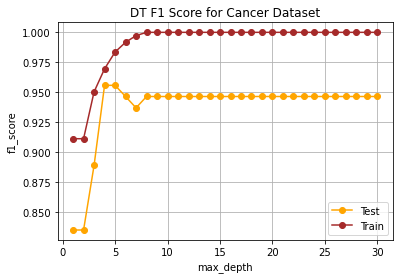

In [4]:
max_depth = np.arange(1,31,1)
f1_test = np.array([])
f1_train = np.array([])
for i in max_depth:
    dt_clf = DecisionTreeClassifier(criterion = 'entropy',
                                    max_depth=i,
                                    random_state=100,
                                    min_samples_leaf=1)
    dt_clf.fit(X_train, y_train)
    y_pred_test = dt_clf.predict(X_test)
    y_pred_train = dt_clf.predict(X_train)
    f1_test = np.append(f1_test,f1_score(y_test, y_pred_test))
    f1_train = np.append(f1_train,f1_score(y_train, y_pred_train))
 
plt.plot(max_depth, f1_test, 'o-', color='orange', label='Test')
plt.plot(max_depth, f1_train, 'o-', color = 'brown', label='Train')
plt.ylabel('f1_score')
plt.xlabel('max_depth')
  
plt.title("DT F1 Score for "+dataset)
plt.legend()
plt.grid()
plt.savefig('img/DT_complexity '+dataset+'.png')
plt.show()

Next the Grid Search was performed, which finds the most optimized parameter of max_depth.

In [5]:
tuned_dt_clf = GridSearchCV(DecisionTreeClassifier(), 
                           param_grid={'max_depth' : max_depth},
                           cv=5)
tuned_dt_clf.fit(X_train, y_train)
best_dt_clf = tuned_dt_clf
best_dt_params = best_dt_clf.best_params_
dt_y_pred = tuned_dt_clf.predict(X_test)
dt_acc = accuracy_score(y_test, dt_y_pred)*100
print(best_dt_params)
print("Tuned Accuracy: %.2f%%"%dt_acc)

{'max_depth': 4}
Tuned Accuracy: 91.97%


Next the code plots the Learning curve which can be used to find bias or varience and if the learning algorithm would benefit from more training data

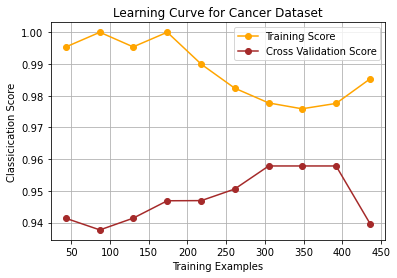

In [6]:
train_sizes, dt_train_scores, test_scores = learning_curve(best_dt_clf,
                                                           X_train,
                                                           y_train,
                                                           train_sizes=np.linspace(0.1,1.0,10))
plt.figure()
plt.plot(train_sizes, np.mean(dt_train_scores, axis=1),'o-',
        label='Training Score',color='orange')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-',
        label='Cross Validation Score',color='brown')
plt.title('Learning Curve for '+dataset)
plt.xlabel('Training Examples')
plt.ylabel('Classicication Score')
plt.legend()
plt.grid()
plt.savefig('img/DT_learning_curve '+dataset+'.png')
plt.show()

Next the code produces a confusion matrix to show the accuracy of the learning algorithm

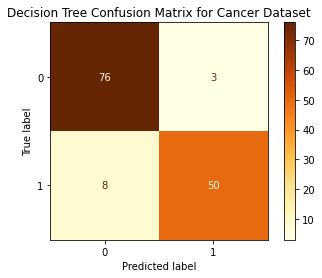

In [7]:
plot_confusion_matrix(best_dt_clf, X_test, y_test, cmap=plt.cm.YlOrBr)
plt.title('Decision Tree Confusion Matrix for '+dataset)
plt.savefig('img/DT_confusion '+dataset+'.png')
plt.show()


# Neural Network

For the Neural Network the code prints out a graph showing how the number of hidden units affects the F1 Score

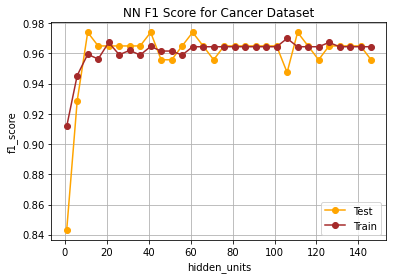

In [8]:
hidden_units = np.arange(1,150,5)
f1_test = np.array([])
f1_train = np.array([])
for i in hidden_units:
    nn_clf = MLPClassifier(hidden_layer_sizes=(i,), random_state=100)
    nn_clf.fit(X_train, y_train)
    y_pred_test = nn_clf.predict(X_test)
    y_pred_train = nn_clf.predict(X_train)
    f1_test = np.append(f1_test,f1_score(y_test, y_pred_test))
    f1_train = np.append(f1_train,f1_score(y_train, y_pred_train))
    
plt.plot(hidden_units, f1_test, 'o-', color='orange', label='Test')
plt.plot(hidden_units, f1_train, 'o-', color='brown', label='Train')
plt.ylabel('f1_score')
plt.xlabel('hidden_units')
plt.title('NN F1 Score for '+dataset)
plt.legend()
plt.grid()
plt.savefig('img/NN_complexity '+dataset+'.png')
plt.show()

next section the code performes a grid search and prints the accuracy, grid search is looking for best amount of hidden units, and the best learning rate that will yield the best accuracy for the given dataset

In [9]:
hidden_units = np.arange(5,100,10)
learning_rate = [0.001, 0.01, 0.05, 0.1, 0.1]
param_grid = {'hidden_layer_sizes' : hidden_units,
              'learning_rate_init' : learning_rate}
tuned_nn_clf = GridSearchCV(MLPClassifier(random_state=100),
                           param_grid=param_grid)
tuned_nn_clf.fit(X_train, y_train)
print('Tuned NN Parameters: ', tuned_nn_clf.best_params_)
nn_y_pred = tuned_nn_clf.predict(X_test)
nn_acc = accuracy_score(y_test, nn_y_pred)*100
print("Tuned Accuracy: %.2f%%"%nn_acc)


Tuned NN Parameters:  {'hidden_layer_sizes': 25, 'learning_rate_init': 0.001}
Tuned Accuracy: 97.08%


Confusion Matrix graphically shows the accuracy of the Neural Network

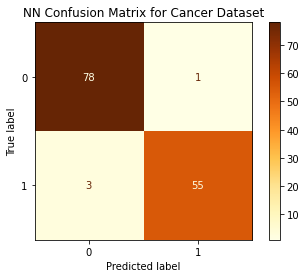

In [10]:
plot_confusion_matrix(tuned_nn_clf, X_test, y_test, cmap=plt.cm.YlOrBr)
plt.title('NN Confusion Matrix for '+dataset)
plt.savefig('img/NN_confusion '+dataset+'.png')
plt.show()


Here we can see the learning curve with tuned classifier

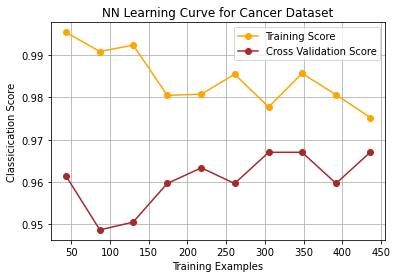

In [11]:
train_sizes, nn_train_scores, test_scores = learning_curve(tuned_nn_clf,
                                                           X_train,
                                                           y_train,
                                                           train_sizes=np.linspace(0.1,1.0,10))
plt.figure()
plt.plot(train_sizes, np.mean(nn_train_scores, axis=1),'o-',
        label='Training Score',color='orange')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-',
        label='Cross Validation Score',color='brown')
plt.title('NN Learning Curve for '+dataset)
plt.xlabel('Training Examples')
plt.ylabel('Classicication Score')
plt.legend()
plt.grid()
plt.savefig('img/NN_learning '+dataset+'.png')
plt.show()

Now the code will print the loss curve for a given dataset, Loss Curve represents overfitting or underfitting

No handles with labels found to put in legend.


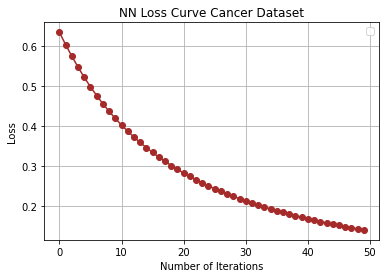

In [12]:
tuned_nn_clf.best_params_
nn_clf = MLPClassifier(hidden_layer_sizes=tuned_nn_clf.best_params_['hidden_layer_sizes'],
                       learning_rate_init=tuned_nn_clf.best_params_['learning_rate_init'],
                       random_state=100, max_iter=50)
nn_clf.fit(X_train, y_train)
nn_loss= nn_clf.loss_curve_
plt.figure()
plt.title('NN Loss Curve '+dataset)

plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.plot(nn_loss, 'o-', color='brown')
plt.grid()
plt.legend()
plt.savefig('img/NN_loss '+dataset+'.png')
plt.show()

# SVM
For the SVM it is important to analyze each kernel, below code will print a graph that will show the F1 Score for each kernel

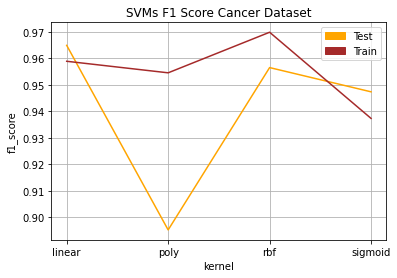

In [13]:
f1_test = np.array([])
f1_train = np.array([])
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
for i in kernel:
    svc_clf = SVC(kernel=i, random_state=100)
    svc_clf.fit(X_train, y_train)
    y_pred_test = svc_clf.predict(X_test)
    y_pred_train = svc_clf.predict(X_train)
    f1_test = np.append(f1_test,f1_score(y_test, y_pred_test))
    f1_train = np.append(f1_train,f1_score(y_train, y_pred_train))
    
x = [1,2,3,4]
y = f1_test
y2 = f1_train
fig, ax = plt.subplots(1,1)
ax.plot(x,y,color='orange')
ax.plot(x,y2,color='brown')
ax.set_xticks(x)
ax.set_xticklabels(kernel)
test_patch = mpatches.Patch(color='orange', label='Test')
train_patch = mpatches.Patch(color='brown', label='Train')
plt.legend(handles=[test_patch, train_patch])
#plt.plot(x, f1_test, '0-', color='r', label='Test F1 Score')
#plt.plot(x, f1_train, '0-', color='b', label='Train F1 Score')
plt.ylabel('f1_score')
plt.xlabel('kernel')
plt.title('SVMs F1 Score '+dataset)
plt.grid()
plt.savefig('img/SVM_complexity '+dataset+'.png')
plt.show()

This section the code will perform a grid search on c, gamma, and kernel. After Grid Search the tuned parameters and the tuned accuracy is printed

In [14]:
c = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]
gamma = [1,10,100, 1000]
param_grid = {'kernel' : ['linear', 'rbf'],
              'C' : c,
              'gamma' : gamma}
tuned_svc_clf = GridSearchCV(SVC(random_state=100),
                             param_grid=param_grid)
tuned_svc_clf.fit(X_train, y_train)
print('SVM tuned paramters: ', tuned_svc_clf.best_params_)
svc_y_pred = tuned_svc_clf.predict(X_test)
svc_acc = accuracy_score(y_test, svc_y_pred)*100
print("Tuned Accuracy: %.2f%%"%svc_acc)

SVM tuned paramters:  {'C': 0.01, 'gamma': 1, 'kernel': 'linear'}
Tuned Accuracy: 97.08%


Now the code will show a plot of the learning curve with tuned parameters

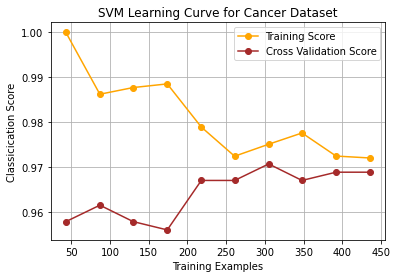

In [15]:
train_sizes = np.linspace(0.1,1.0,10)
train_sizes, svm_train_scores, test_scores = learning_curve(tuned_svc_clf,
                                                        X_train,
                                                        y_train,
                                                        train_sizes=train_sizes)
plt.figure()
plt.plot(train_sizes, np.mean(svm_train_scores, axis=1),'o-',
        label='Training Score',color='orange')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-',
        label='Cross Validation Score',color='brown')
plt.title('SVM Learning Curve for '+dataset)
plt.xlabel('Training Examples')
plt.ylabel('Classicication Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('img/SVM_learning '+dataset+'.png')
plt.show()

Next Confusion Matrix can be viewed to see in graphical format the accuracy of the learning algorithm

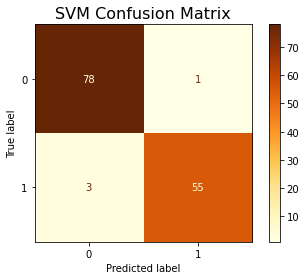

In [16]:
plot_confusion_matrix(tuned_svc_clf, X_test, y_test, cmap=plt.cm.YlOrBr)
plt.title('SVM Confusion Matrix',fontsize=16)
plt.savefig('img/SVM_confusion '+dataset+'.png')
plt.show()


# Boosting

for the Gradient boosting classifier one of the main things to tune is the number of estimators, this code priunts a graph that shows how the number of estimators can improve the accuracy of this classifier

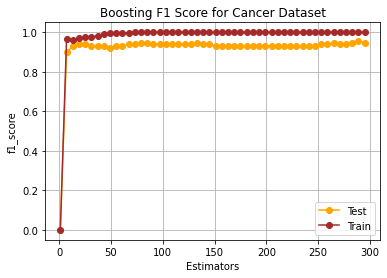

In [17]:
f1_test = np.array([])
f1_train = np.array([])
n = np.arange(1,300,6)
for i in n:
    boost_clf = GradientBoostingClassifier(n_estimators=i,
                                           random_state=100)
    boost_clf.fit(X_train, y_train)
    y_pred_test = boost_clf.predict(X_test)
    y_pred_train = boost_clf.predict(X_train)
    f1_test = np.append(f1_test,f1_score(y_test, y_pred_test))
    f1_train = np.append(f1_train,f1_score(y_train, y_pred_train))
    
plt.plot(n, f1_test, 'o-', color='orange', label='Test')
plt.plot(n, f1_train, 'o-', color='brown', label='Train')
plt.ylabel('f1_score')
plt.xlabel('Estimators')
plt.title('Boosting F1 Score for '+dataset)
plt.grid()
plt.legend()
plt.savefig('img/boosting_complexity '+dataset+'.png')
plt.show()

This is the most extentive Grid Search in this project, code below analyzes min_samples_leaf, max_depth, n_estimators, learning_rates. After usually long analysis this piece of code will print out those tuned paramteres for the given dataset

In [18]:
min_samples_leaf = np.linspace(0.1, 0.5, 5, endpoint=True)
max_depth = np.arange(1,4)
n_estimators = np.arange(1,60,6)
learning_rates = np.linspace(.001,.1,3)
param_grid = {'min_samples_leaf' : min_samples_leaf,
              'max_depth' : max_depth,
              'n_estimators' : n_estimators,
              'learning_rate' : learning_rate}
tuned_boost_clf = GridSearchCV(GradientBoostingClassifier(),
                               param_grid = param_grid)
tuned_boost_clf.fit(X_train, y_train)
print("Tuned Boosting Parameters: ", tuned_boost_clf.best_params_)
boost_y_pred = tuned_boost_clf.predict(X_test)
boost_acc = accuracy_score(y_test, boost_y_pred)*100
print("Tuned Accuracy: %.2f%%"%boost_acc)

Tuned Boosting Parameters:  {'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 0.30000000000000004, 'n_estimators': 31}
Tuned Accuracy: 91.24%


now the code will show a confusion matrix, which is a graphical way of seeing the accuracy of the classifier.

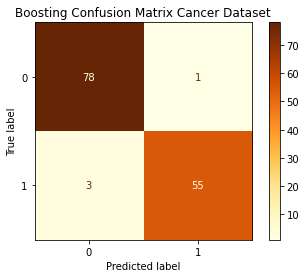

In [19]:
plot_confusion_matrix(tuned_svc_clf, X_test, y_test, cmap=plt.cm.YlOrBr)
plt.title('Boosting Confusion Matrix '+dataset)
plt.savefig('img/boosting_confusion '+dataset+'.png')
plt.show()


now the code will print the learning curve with the tuned parameters

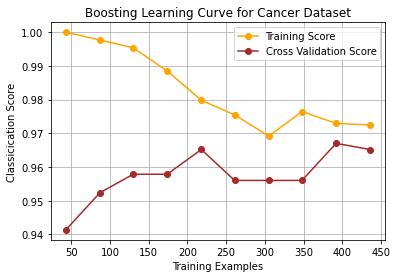

In [20]:
train_sizes = np.linspace(0.1,1.0,10)
train_sizes, boost_train_scores, test_scores = learning_curve(tuned_boost_clf,
                                                        X_train,
                                                        y_train,
                                                        train_sizes=train_sizes)
plt.figure()
plt.plot(train_sizes, np.mean(boost_train_scores, axis=1),'o-',
        label='Training Score',color='orange')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-',
        label='Cross Validation Score',color='brown')
plt.title('Boosting Learning Curve for '+dataset)
plt.xlabel('Training Examples')
plt.ylabel('Classicication Score')
plt.legend()
plt.grid()
plt.savefig('img/boosting_learning '+dataset+'.png')
plt.show()

# KNN

now the code will print an f1 score curve when compared to the number of k nearest neighbors

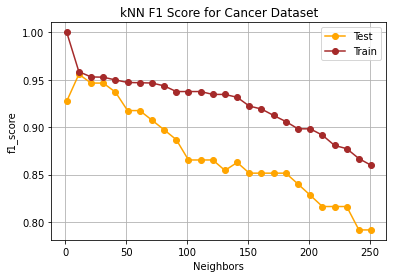

In [21]:
f1_test = np.array([])
f1_train = np.array([])
ks = np.arange(1,260,10)
for i in ks:
    knn_clf = KNeighborsClassifier(n_neighbors = i)
    knn_clf.fit(X_train, y_train)
    y_pred_test = knn_clf.predict(X_test)
    y_pred_train = knn_clf.predict(X_train)
    f1_test = np.append(f1_test,f1_score(y_test, y_pred_test))
    f1_train = np.append(f1_train,f1_score(y_train, y_pred_train))
    
plt.plot(ks, f1_test, 'o-', color='orange', label='Test')
plt.plot(ks, f1_train, 'o-', color='brown', label='Train')
plt.ylabel("f1_score")
plt.xlabel("Neighbors")
plt.title('kNN F1 Score for '+dataset)
plt.grid()
plt.legend()
plt.savefig('img/kNN_complexity '+dataset+'.png')
plt.show()

now the code will perform a Grid Search on kNN searching for the best amount of nearest neighbors, type of weights, type of metric

In [22]:
ks = np.arange(1,260,10)
param_grid = {'n_neighbors' : ks,
           'weights' : ['uniform', 'distance'],
           'metric': ['euclidean', 'manhattan']}
tuned_knn_clf = GridSearchCV(KNeighborsClassifier(),
                             param_grid=param_grid)
tuned_knn_clf.fit(X_train, y_train)
print("Tuned Boosted DT Parameters: ", tuned_knn_clf.best_params_)
knn_y_pred = tuned_boost_clf.predict(X_test)
knn_acc = accuracy_score(y_test, knn_y_pred)*100
print("Tuned Accuracy: %.2f%%"%knn_acc)
print(tuned_knn_clf.best_params_['n_neighbors'])

Tuned Boosted DT Parameters:  {'metric': 'euclidean', 'n_neighbors': 51, 'weights': 'distance'}
Tuned Accuracy: 91.24%
51


this section of code will create a Confusion Matrix, to graphically show the accuracy of the classifier

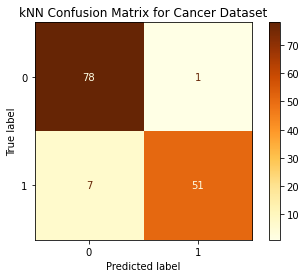

In [23]:
plot_confusion_matrix(tuned_knn_clf, X_test, y_test, cmap=plt.cm.YlOrBr)
plt.title('kNN Confusion Matrix for '+dataset)
plt.savefig('img/kNN_confusion '+dataset+'.png')
plt.show()

next section will show a plot with the tuned parameters

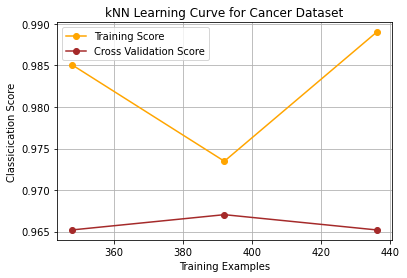

In [24]:
train_sizes, knn_train_scores, test_scores = learning_curve(tuned_knn_clf,
                                                        X_train,
                                                        y_train,
                                                        train_sizes=np.linspace(0.1,1.0,10))
plt.figure()
plt.plot(train_sizes, np.mean(knn_train_scores, axis=1),'o-',
        label='Training Score',color='orange')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-',
        label='Cross Validation Score',color='brown')
plt.title('kNN Learning Curve for '+dataset)
plt.xlabel('Training Examples')
plt.ylabel('Classicication Score')
plt.legend()
plt.grid()
plt.savefig('img/kNN_learning '+dataset+'.png')
plt.show()

# Learning Rate Comparison

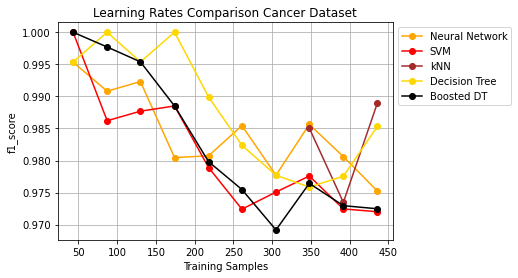

In [25]:
plt.figure()
plt.title('Learning Rates Comparison '+dataset)
plt.xlabel('Training Samples')
plt.ylabel('f1_score')
plt.plot(train_sizes, np.mean(nn_train_scores, axis=1), 'o-', color="orange", label="Neural Network")
plt.plot(train_sizes, np.mean(svm_train_scores, axis=1), 'o-', color="red", label="SVM")
plt.plot(train_sizes, np.mean(knn_train_scores, axis=1), 'o-', color="brown", label="kNN")
plt.plot(train_sizes, np.mean(dt_train_scores, axis=1), 'o-', color="gold", label="Decision Tree")
plt.plot(train_sizes, np.mean(boost_train_scores, axis=1), 'o-', color="black", label="Boosted DT")
plt.grid()
lgd = plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.savefig('img/learning_rates_comparison '+dataset+'.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# Data prep for the train and fit times plots

In [26]:
#DT Best Parameters
dt_max_depth = tuned_dt_clf.best_params_['max_depth']
#NN Best Parameters
nn_hlayers_size = tuned_nn_clf.best_params_['hidden_layer_sizes']
nn_learning_rate = tuned_nn_clf.best_params_['learning_rate_init']
#SVM Best Parameters
svm_C = tuned_svc_clf.best_params_['C']
svm_gamma = tuned_svc_clf.best_params_['gamma']
svm_kernel = tuned_svc_clf.best_params_['kernel']
#Boosting Best Parameters
boost_learning_rate = tuned_boost_clf.best_params_['learning_rate']
boost_max_depth = tuned_boost_clf.best_params_['max_depth']
boost_min_samples_leaf = tuned_boost_clf.best_params_['min_samples_leaf']
boost_n_estimators = tuned_boost_clf.best_params_['n_estimators']
#kNN Best Parameters
knn_metric = tuned_knn_clf.best_params_['metric']
knn_n_neighbors = tuned_knn_clf.best_params_['n_neighbors']
knn_weights = tuned_knn_clf.best_params_['weights']

In [27]:
_dt_clf = DecisionTreeClassifier(max_depth = dt_max_depth,
                                random_state=100)
dt_scores = cross_validate(_dt_clf,
                           X,
                           y_save,
                           cv=10,
                           scoring='f1',
                           return_train_score=True)


_nn_clf = MLPClassifier(hidden_layer_sizes=nn_hlayers_size,
                        learning_rate_init=nn_learning_rate,
                        random_state=100)
nn_scores = cross_validate(_nn_clf,
                           X,
                           y_save,
                           cv=10,
                           scoring='f1',
                           return_train_score=True)


_svm_clf = SVC(C=svm_C,
               gamma=svm_gamma,
               kernel=svm_kernel,
               random_state=100)
svm_scores = cross_validate(_svm_clf,
                            X,
                            y_save,
                            cv=10,
                            scoring='f1',
                            return_train_score=True)


_boost_clf = GradientBoostingClassifier(learning_rate=boost_learning_rate,
                                       max_depth=boost_max_depth,
                                       min_samples_leaf=boost_min_samples_leaf,
                                       n_estimators=boost_n_estimators,
                                       random_state=100)
boost_scores = cross_validate(_boost_clf,
                              X,
                              y_save,
                              cv=10,
                              scoring='f1',
                              return_train_score=True)


_knn_clf = KNeighborsClassifier(metric=knn_metric,
                                n_neighbors=knn_n_neighbors,
                                weights=knn_weights)
knn_scores = cross_validate(_knn_clf,
                            X,
                            y_save,
                            cv=10,
                            scoring='f1',
                            return_train_score=True)

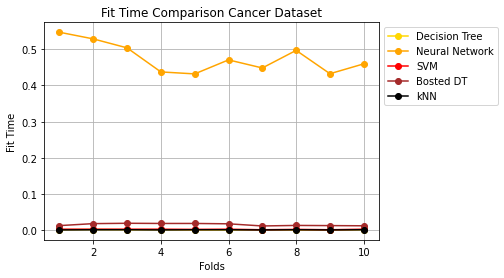

In [28]:
x_ticks = np.arange(1,11,1)
plt.figure()
plt.title('Fit Time Comparison '+dataset)
plt.xlabel('Folds')
plt.ylabel('Fit Time')
plt.plot(x_ticks,dt_scores['fit_time'], 'o-', color="gold", label="Decision Tree")
plt.plot(x_ticks, nn_scores['fit_time'], 'o-', color="orange", label="Neural Network")
plt.plot(x_ticks, svm_scores['fit_time'], 'o-', color="red", label="SVM")
plt.plot(x_ticks, boost_scores['fit_time'], 'o-', color="brown", label="Bosted DT")
plt.plot(x_ticks, knn_scores['fit_time'], 'o-', color="black", label="kNN")
plt.grid()
lgd = plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.savefig('img/fit_time_comparison '+dataset+'.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

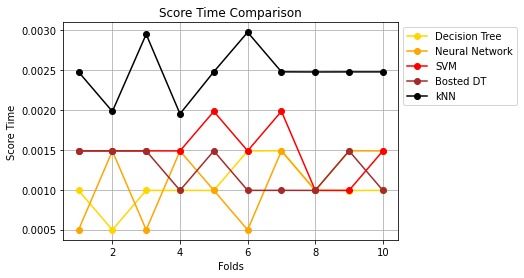

In [29]:
x_ticks = np.arange(1,11,1)
plt.figure()
plt.title('Score Time Comparison')
plt.xlabel('Folds')
plt.ylabel('Score Time')
plt.plot(x_ticks,dt_scores['score_time'], 'o-', color="gold", label="Decision Tree")
plt.plot(x_ticks, nn_scores['score_time'], 'o-', color="orange", label="Neural Network")
plt.plot(x_ticks, svm_scores['score_time'], 'o-', color="red", label="SVM")
plt.plot(x_ticks, boost_scores['score_time'], 'o-', color="brown", label="Bosted DT")
plt.plot(x_ticks, knn_scores['score_time'], 'o-', color="black", label="kNN")
plt.grid()
lgd = plt.legend(bbox_to_anchor=(1,1),loc='upper left')
plt.savefig('img/score_time_comparison '+dataset+'.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# Plot of the Accuracy Comparison

[]

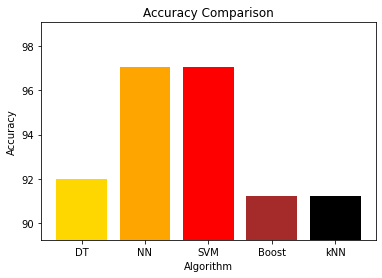

In [30]:
bars=('DT','NN','SVM','Boost','kNN')
y_pos=np.arange(len(bars))
height = [dt_acc,nn_acc,svc_acc,boost_acc,knn_acc]
color = ['gold', 'orange', 'red', 'brown', 'black']
plt.bar(y_pos, height, color=color)
plt.ylim(min(height)-2, max(height)+2)
plt.xticks(y_pos,bars)
plt.title("Accuracy Comparison")
plt.ylabel('Accuracy')
plt.xlabel('Algorithm')
plt.savefig('img/accuracy_comparison '+dataset+'.png')
plt.plot()

In [31]:
print("Total Time: ", time.time() - start_time)

Total Time:  1990.1765916347504
